In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


1. Data Preparation

In [17]:
# Load the dataset
df = pd.read_csv('/content/Telco_Customer_Churn_Dataset  (1).csv')
print("Dataset loaded successfully.")

print("\nInitial DataFrame Info:")
df.info()

Dataset loaded successfully.

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   o

In [22]:

print("\nFirst 5 rows of the dataset:")
print(df.head())
# Handle 'TotalCharges' column: Convert to numeric, coercing errors to NaN
# The context shows some 'TotalCharges' values might be spaces, which pandas reads as objects.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV Stream

In [ ]:
# Handle missing values in 'TotalCharges' (which resulted from 'coerce' or actual NaNs)
# A common strategy for a few missing values is to drop rows or impute.
# Given the context, it seems like a few rows might have empty strings for TotalCharges.
# Let's fill them with 0 or the mean/median, or drop them. For simplicity, let's fill with 0
# as it implies no charges yet for new customers (tenure 0).

print(f"\nMissing values before handling TotalCharges: {df.isnull().sum().sum()}")
df['TotalCharges'].fillna(0, inplace=True)
print(f"\nMissing values after handling TotalCharges: {df.isnull().sum().sum()}")

# Drop customerID as it's just an identifier and not useful for modeling
df.drop('customerID', axis=1, inplace=True)
print("\n'customerID' column dropped.")

# Convert 'No phone service' and 'No internet service' to 'No' for consistency
# This simplifies encoding later.
for col in ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})
print("\n'No phone service' and 'No internet service' values standardized to 'No'.")

# Convert 'gender' column to numerical (Male: 0, Female: 1)
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
print("\n'gender' column encoded (Male: 0, Female: 1).")

# Convert 'Partner' and 'Dependents' to numerical (Yes: 1, No: 0)
for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
print("\n'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn' columns encoded (Yes: 1, No: 0).")

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) # drop_first avoids multicollinearity
print(f"\nCategorical columns one-hot encoded: {list(categorical_cols)}")
print("\nDataFrame after one-hot encoding:")
print(df.head())

In [24]:
# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']
print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")


Features (X) shape: (7043, 23)
Target (y) shape: (7043,)


2. Split Data into Training and Testing Sets

In [25]:
# Split the data (80% train, 20% test)
# stratify=y ensures that the proportion of churned/non-churned customers is the same in both train and test sets
# random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print("\nChurn distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nChurn distribution in test set:")
print(y_test.value_counts(normalize=True))
# Scale numerical features (important for many models, especially those sensitive to feature scales like Logistic Regression, SVMs, Neural Networks)
# Fit scaler only on training data to prevent data leakage
scaler = StandardScaler()
numerical_cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges'] # Identify numerical columns
X_train[numerical_cols_to_scale] = scaler.fit_transform(X_train[numerical_cols_to_scale])
X_test[numerical_cols_to_scale] = scaler.transform(X_test[numerical_cols_to_scale]) # Transform test set using scaler fitted on train
print("\nNumerical features scaled.")
print(X_train.head())

X_train shape: (5634, 23)
X_test shape: (1409, 23)
y_train shape: (5634,)
y_test shape: (1409,)

Churn distribution in training set:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

Churn distribution in test set:
Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64

Numerical features scaled.
      gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
3738       0              0        0           0  0.102371             0   
3151       0              0        1           1 -0.711743             1   
4860       0              0        1           1 -0.793155             0   
3867       1              0        1           0 -0.263980             1   
3810       0              0        1           1 -1.281624             1   

      PaperlessBilling  MonthlyCharges  TotalCharges  MultipleLines_Yes  ...  \
3738                 0       -0.521976     -0.262257              False  ...   
3151                 0        0.337478     -0.503635   

 4. Model Selection

In [26]:
# - LogisticRegression (good baseline, interpretable)
# - GradientBoostingClassifier (e.g., XGBoost, LightGBM - often top performers)
# - SVC (Support Vector Classifier)
# - K-Nearest Neighbors (KNN)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# 'class_weight='balanced'' is important for imbalanced datasets like churn,
# as it automatically adjusts weights inversely proportional to class frequencies.
print(f"Selected Model: {type(model).__name__}")
print("Model initialized with default parameters (n_estimators=100, random_state=42, class_weight='balanced').")

Selected Model: RandomForestClassifier
Model initialized with default parameters (n_estimators=100, random_state=42, class_weight='balanced').


5. Model Training

In [27]:
# Train the model on the training data
model.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


6. Model Evaluation (Added for completeness, crucial for project success)


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409


Confusion Matrix:
[[930 105]
 [195 179]]


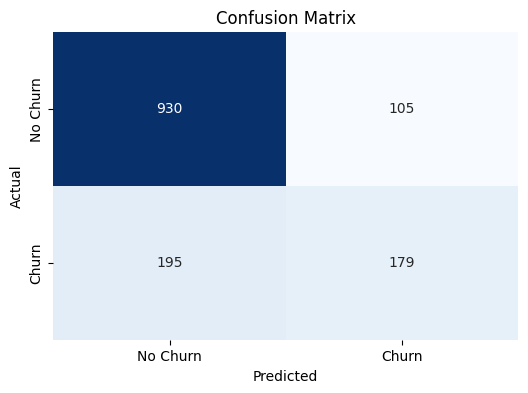


ROC AUC Score: 0.8236


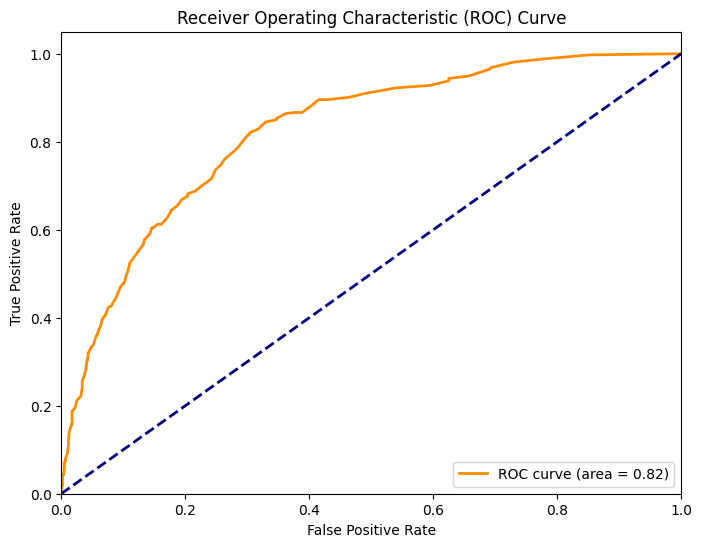


Top 10 Feature Importances:
TotalCharges                      0.176142
tenure                            0.168399
MonthlyCharges                    0.167053
Contract_Two year                 0.060298
InternetService_Fiber optic       0.053178
PaymentMethod_Electronic check    0.038478
Contract_One year                 0.028729
gender                            0.026028
PaperlessBilling                  0.026014
OnlineSecurity_Yes                0.025449
dtype: float64


/tmp/ipython-input-28-2033700756.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index, palette='viridis')


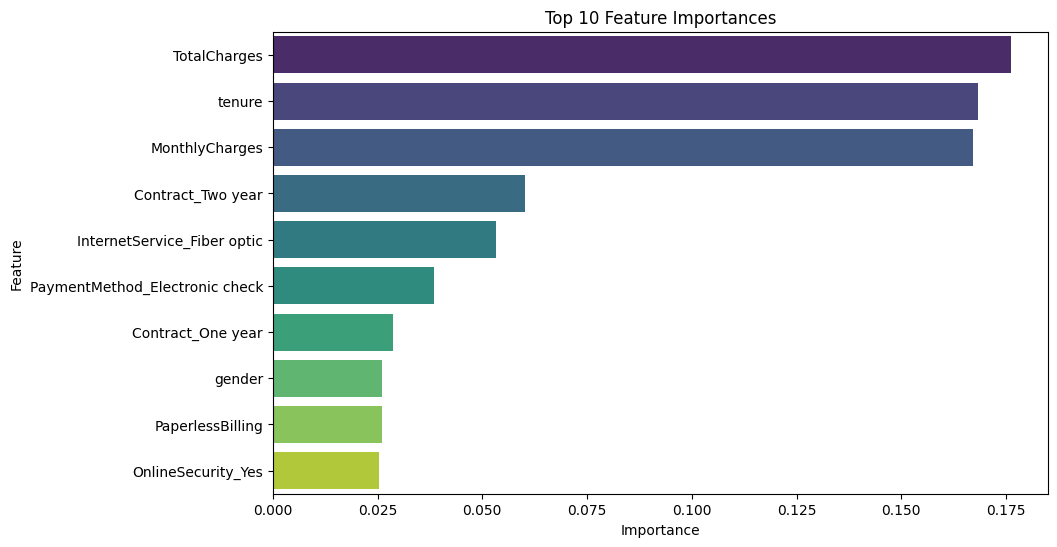


--- Project Workflow Complete ---
The model has been trained and evaluated. Further steps would involve hyperparameter tuning,
more advanced feature engineering, and deploying the model for real-world predictions.


In [28]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probability of the positive class (churn)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Feature Importance (for tree-based models like RandomForest)
if hasattr(model, 'feature_importances_'):
    feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
    feature_importances = feature_importances.sort_values(ascending=False)
    print("\nTop 10 Feature Importances:")
    print(feature_importances.head(10))
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.head(10).values, y=feature_importances.head(10).index, palette='viridis')
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

print("\n--- Project Workflow Complete ---")
print("The model has been trained and evaluated. Further steps would involve hyperparameter tuning,")
print("more advanced feature engineering, and deploying the model for real-world predictions.")